Dataset shape: (11904, 6)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           11904 non-null  object
 1   published_date  11904 non-null  object
 2   reporter        10914 non-null  object
 3   category        11904 non-null  object
 4   url             11904 non-null  object
 5   content         11904 non-null  object
dtypes: object(6)
memory usage: 558.1+ KB
None

First few rows:
                                               title  \
0  সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...   
1             এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি!   
2  ২০৩০ ও ২০৩৪ বিশ্বকাপের হোস্ট জানা যাবে দুইদিন পর!   
3  প্যারিস অলিম্পিক: কোয়ার্টার ফাইনালে ওঠার লক্ষ্...   
4                আজ টিভিতে যা দেখবেন (৩০ জুলাই ২০২৪)   

             published_date reporter category                            url  \
0   30th July, 202

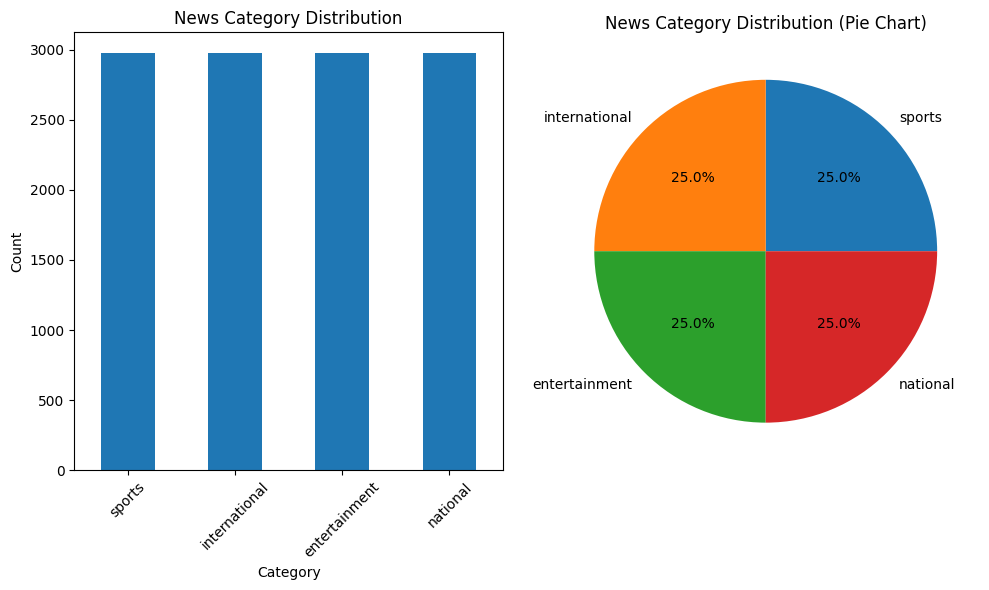


Total number of news articles: 11904
Number of categories: 4
Categories: ['sports', 'international', 'entertainment', 'national']
Cleaning data...
Dataset shape after cleaning: (11904, 9)
Removed 0 rows with empty text


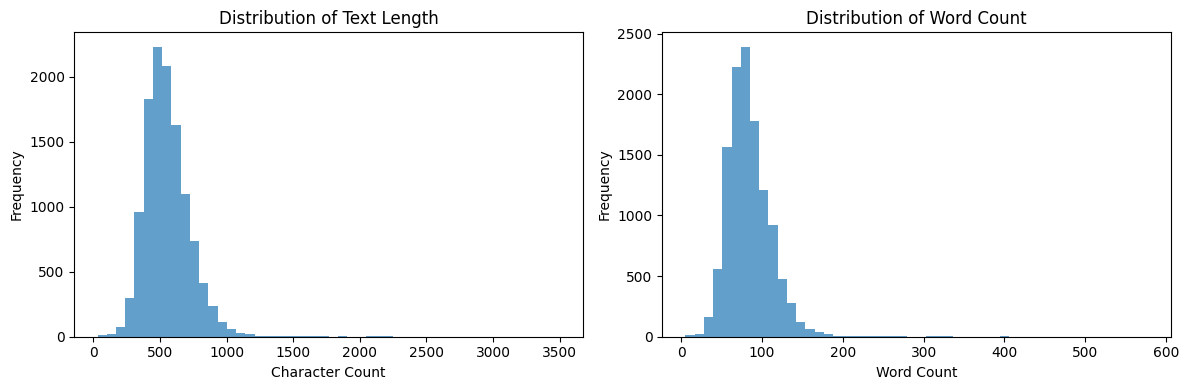


Category-wise statistics:
              text_length         word_count       
                     mean     std       mean    std
category                                           
entertainment      601.58  234.99      93.19  37.01
international      520.75  132.62      76.86  20.06
national           483.32  124.75      72.80  19.05
sports             617.81  169.85      94.29  26.75
Training set size: 9523
Test set size: 2381
Vectorizing text...
Feature matrix shape: (9523, 10000)
Training models...

Training Naive Bayes...
Naive Bayes Accuracy: 0.9311
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

entertainment       0.89      0.94      0.92       595
international       0.95      0.91      0.93       595
     national       0.92      0.94      0.93       596
       sports       0.98      0.93      0.95       595

     accuracy                           0.93      2381
    macro avg       0.93      0.93      0.93      2381
 weighted 

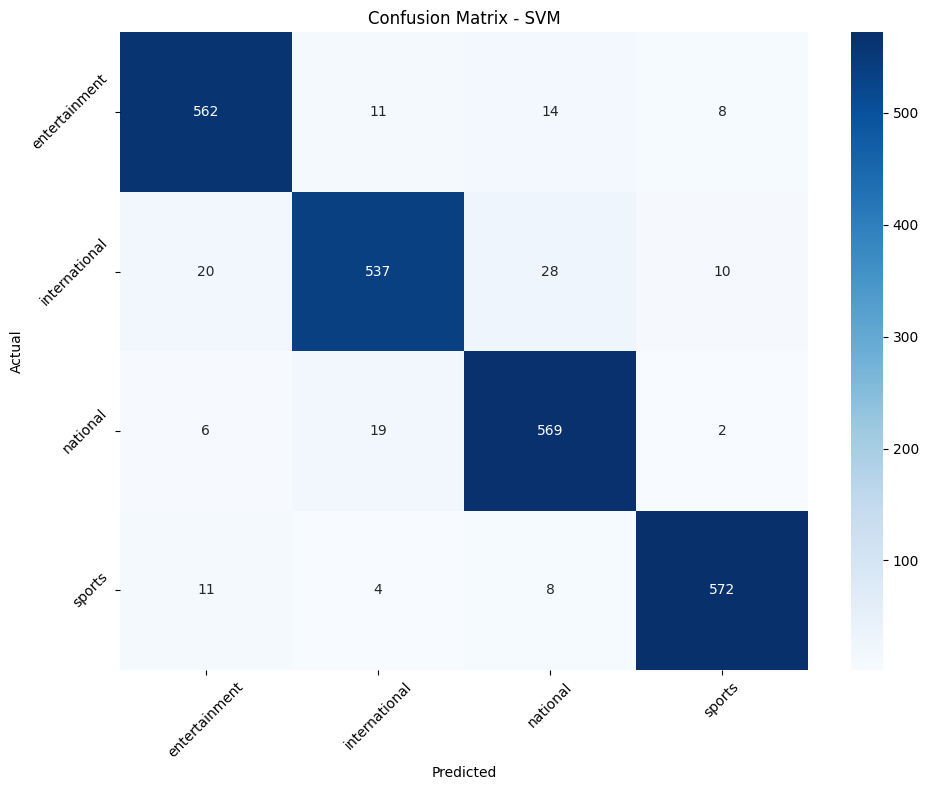

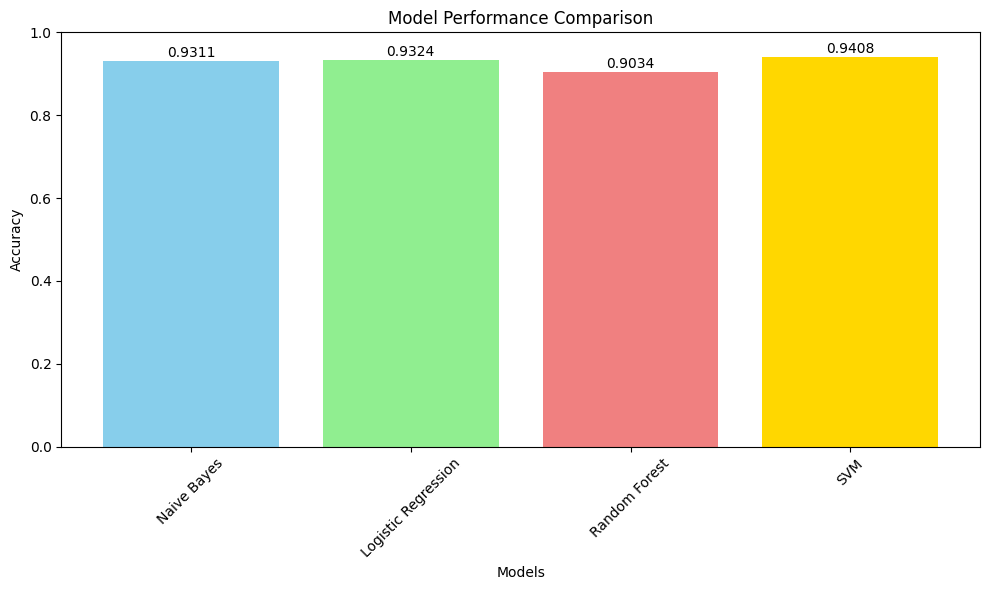

Model training and evaluation completed!
Best model (SVM) saved and ready for deployment.


In [ ]:
# Bangla News Category Prediction and Recommendation System

## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load and Explore Data
# Load the dataset
df = pd.read_csv("Bangla_news.csv")
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

## Data Exploration and Visualization
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Category distribution
plt.figure(figsize=(10, 6))
category_counts = df['category'].value_counts()
plt.subplot(1, 2, 1)
category_counts.plot(kind='bar')
plt.title('News Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('News Category Distribution (Pie Chart)')
plt.tight_layout()
plt.show()

# Basic statistics
print(f"\nTotal number of news articles: {len(df)}")
print(f"Number of categories: {df['category'].nunique()}")
print(f"Categories: {df['category'].unique().tolist()}")

## Data Cleaning and Preprocessing
def clean_bangla_text(text):
    """Clean Bangla text by removing unwanted characters and normalizing"""
    if pd.isna(text):
        return ""
    
    # Convert to string if not already
    text = str(text)
    
    # Remove English characters and numbers (keep only Bangla and basic punctuation)
    text = re.sub(r'[a-zA-Z0-9]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters except basic punctuation
    text = re.sub(r'[^\u0980-\u09FF\s।,;:!?]', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Clean the data
print("Cleaning data...")
df_clean = df.copy()

# Handle missing values
df_clean['title'] = df_clean['title'].fillna('')
df_clean['content'] = df_clean['content'].fillna('')
df_clean['category'] = df_clean['category'].fillna('unknown')

# Clean text columns
df_clean['title_clean'] = df_clean['title'].apply(clean_bangla_text)
df_clean['content_clean'] = df_clean['content'].apply(clean_bangla_text)

# Combine title and content for better feature extraction
df_clean['text_combined'] = df_clean['title_clean'] + ' ' + df_clean['content_clean']

# Remove rows with empty combined text
df_clean = df_clean[df_clean['text_combined'].str.strip() != '']

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with empty text")

## Feature Engineering
# Text length analysis
df_clean['text_length'] = df_clean['text_combined'].str.len()
df_clean['word_count'] = df_clean['text_combined'].str.split().str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df_clean['text_length'], bins=50, alpha=0.7)
plt.title('Distribution of Text Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_clean['word_count'], bins=50, alpha=0.7)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Category-wise text statistics
print("\nCategory-wise statistics:")
category_stats = df_clean.groupby('category').agg({
    'text_length': ['mean', 'std'],
    'word_count': ['mean', 'std']
}).round(2)
print(category_stats)

## Model Training and Evaluation
# Prepare features and target
X = df_clean['text_combined']
y = df_clean['category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Vectorize text using TF-IDF
print("Vectorizing text...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words=None  # No built-in Bangla stopwords, can add custom list
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_tfidf.shape}")

# Train multiple models
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

model_results = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Select best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name} with accuracy: {model_results[best_model_name]['accuracy']:.4f}")

## Recommendation System
class NewsRecommendationSystem:
    def __init__(self, vectorizer, model, df, similarity_threshold=0.1):
        self.vectorizer = vectorizer
        self.model = model
        self.df = df
        self.similarity_threshold = similarity_threshold
        
        # Pre-compute TF-IDF matrix for all news articles
        self.tfidf_matrix = self.vectorizer.transform(self.df['text_combined'])
    
    def predict_category(self, text):
        """Predict category for given text"""
        text_clean = clean_bangla_text(text)
        text_tfidf = self.vectorizer.transform([text_clean])
        prediction = self.model.predict(text_tfidf)[0]
        probabilities = self.model.predict_proba(text_tfidf)[0] if hasattr(self.model, 'predict_proba') else None
        
        return prediction, probabilities
    
    def recommend_similar_news(self, text, top_k=5):
        """Recommend similar news articles"""
        text_clean = clean_bangla_text(text)
        text_tfidf = self.vectorizer.transform([text_clean])
        
        # Calculate cosine similarity
        similarities = cosine_similarity(text_tfidf, self.tfidf_matrix).flatten()
        
        # Get top-k most similar articles (excluding perfect matches)
        similar_indices = similarities.argsort()[::-1]
        
        recommendations = []
        for idx in similar_indices:
            if len(recommendations) >= top_k:
                break
            if similarities[idx] > self.similarity_threshold and similarities[idx] < 0.99:  # Exclude perfect matches
                recommendations.append({
                    'index': idx,
                    'title': self.df.iloc[idx]['title'],
                    'category': self.df.iloc[idx]['category'],
                    'similarity': similarities[idx],
                    'url': self.df.iloc[idx]['url'] if 'url' in self.df.columns else None
                })
        
        return recommendations

# Initialize recommendation system
recommender = NewsRecommendationSystem(vectorizer, best_model, df_clean)

## Test the System
# Test with a sample news
sample_text = df_clean.iloc[0]['text_combined']
sample_title = df_clean.iloc[0]['title']

print(f"\nTesting with sample news: {sample_title[:100]}...")

# Predict category
predicted_category, probabilities = recommender.predict_category(sample_text)
print(f"Predicted Category: {predicted_category}")

if probabilities is not None:
    print("Category Probabilities:")
    categories = best_model.classes_
    for cat, prob in zip(categories, probabilities):
        print(f"  {cat}: {prob:.4f}")

# Get recommendations
recommendations = recommender.recommend_similar_news(sample_text, top_k=5)
print(f"\nTop 5 Similar News:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title'][:100]}... (Category: {rec['category']}, Similarity: {rec['similarity']:.4f})")

## Save Models and Data
print("\nSaving models and preprocessed data...")

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save cleaned dataset for the recommendation system
df_clean.to_csv('cleaned_bangla_news.csv', index=False)

# Save model metadata
model_info = {
    'best_model_name': best_model_name,
    'accuracy': model_results[best_model_name]['accuracy'],
    'categories': best_model.classes_.tolist(),
    'feature_count': X_train_tfidf.shape[1]
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Models and data saved successfully!")
print(f"Files created:")
print("- best_model.pkl")
print("- vectorizer.pkl") 
print("- cleaned_bangla_news.csv")
print("- model_info.pkl")

## Model Evaluation Visualization
# Confusion Matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, model_results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Model comparison
plt.figure(figsize=(10, 6))
model_names = list(model_results.keys())
accuracies = [model_results[name]['accuracy'] for name in model_names]

plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Model training and evaluation completed!")
print(f"Best model ({best_model_name}) saved and ready for deployment.")